# Chapter 3. Classification

## Setup

In [2]:
# Test python version
import sys

assert sys.version_info >= (3, 5)

# Test sklearn version
import sklearn

assert sklearn.__version__ >= "0.20"

import os

# Common imports
import numpy as np

# Ensure outputs are stable across runs for numpy
np.random.seed(42)

# Matplotlib settings
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

PROJECT_ROOT = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)

    if tight_layout:
        plt.tight_layout()

    plt.savefig(path, format=fig_extension, dpi=resolution)

## MNIST Dataset

In [3]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", version=1)

In [4]:
X, y = mnist["data"], mnist["target"]

5


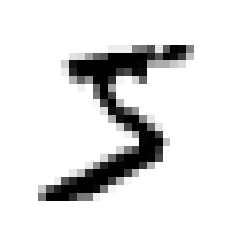

In [5]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
print(y[0])

## Stochastic Gradient Descent Classifier

### Only-5 classfiier

In [6]:
y = y.astype(np.uint8)

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [8]:
y_train_5 = y_train == 5
y_test_5 = y_test == 5

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [10]:
sgd_clf.predict([some_digit])

array([ True])

## Measuring accuracy using CV

### Confusion Matrix

In [11]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, n_jobs=3)

array([0.95035, 0.96035, 0.9604 ])

In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, n_jobs=3)
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

### Precision and Recall

In [13]:
from sklearn.metrics import precision_score, recall_score

print("Precision score =", precision_score(y_train_5, y_train_pred))
print("Recall score =", recall_score(y_train_5, y_train_pred))

Precision score = 0.8370879772350012
Recall score = 0.6511713705958311


### $$F_1 Score$$

In [14]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

### Precision/Recall Tradeoff

In [15]:
# We can manually access the decision scores used by sklearn
# to favor precision over recall or vice-versa
y_train_scores = cross_val_predict(
    sgd_clf, X_train, y_train_5, cv=3, n_jobs=3, method="decision_function"
)
print(f"y_train_score = {y_train_scores[:5]}")

threshold = 0  # Default behavior
y_train_pred = y_train_scores > threshold
y_train_pred

y_train_score = [  1200.93051237 -26883.79202424 -33072.03475406 -15919.5480689
 -20003.53970191]


array([ True, False, False, ...,  True, False, False])

In [16]:
threshold = 8000  # Raising reduces recall
y_train_pred = y_train_scores > threshold
y_train_pred

array([False, False, False, ...,  True, False, False])

In [17]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_train_scores)

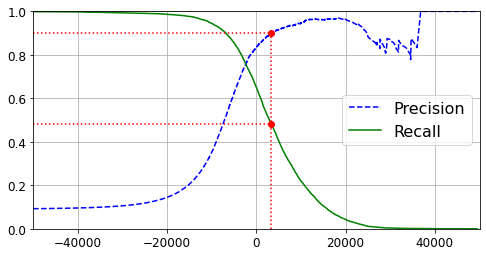

In [18]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend(loc="center right", fontsize=16)
    plt.grid(b=True)
    plt.axis([-50000, 50000, 0, 1])


recall_90_precision = recalls[np.argmax(precisions >= 0.9)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0, 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")
plt.plot(
    [-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:"
)
plt.plot([threshold_90_precision], [0.9], "ro")
plt.plot([threshold_90_precision], [recall_90_precision], "ro")

In [19]:
y_train_pred_90 = y_train_scores >= threshold_90_precision

print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9000345901072293
0.4799852425751706


### ROC Curve

In [20]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--")  # Diagonal dashed line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(b=True)
    plt.axis([0, 1, 0, 1])

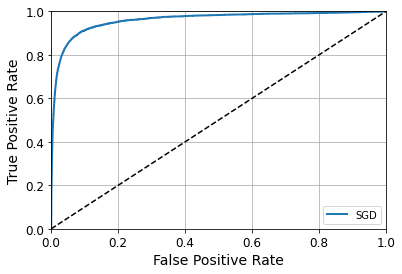

In [21]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_train_scores)

plot_roc_curve(fpr, tpr, label="SGD")

In [22]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_train_scores)

0.9604938554008616

In [23]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(
    forest_clf, X_train, y_train_5, cv=3, n_jobs=3, method="predict_proba"
)

In [24]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

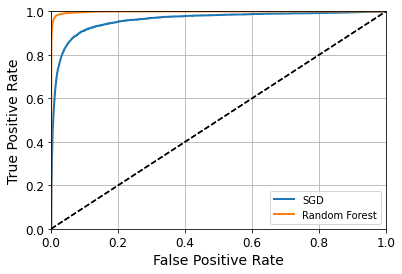

In [25]:
plot_roc_curve(fpr, tpr, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, label="Random Forest")

In [26]:
roc_auc_score(y_train_5, y_scores_forest)
print(precision_score(y_train_5, y_scores_forest >= 0.5))
print(recall_score(y_train_5, y_scores_forest >= 0.5))

0.9897468089558485
0.8725327430363402


### Multiclass Classifications

In [27]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)  # The whole y_train

SVC()

In [31]:
print(svm_clf.predict([some_digit]))
some_digit_scores = svm_clf.decision_function([some_digit])
print(some_digit_scores)
svm_clf.classes_[np.argmax(some_digit_scores)]

[5]
[[ 1.72501977  2.72809088  7.2510018   8.3076379  -0.31087254  9.3132482
   1.70975103  2.76765202  6.23049537  4.84771048]]


5

In [32]:
# Forcing an OvR classifier
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
ovr_clf.predict([some_digit])

In [ ]:
sgd_clf.fit(X_train, y_train)

In [36]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, n_jobs=6, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [39]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [42]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [44]:
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, n_jobs=6, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## Error Analysis

In [45]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3, n_jobs=5)

In [49]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

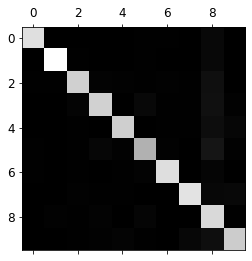

In [50]:
plt.matshow(conf_mx, cmap=plt.cm.gray)

In [61]:
row_sum = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sum
np.fill_diagonal(norm_conf_mx, 0)

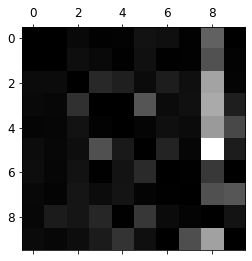

In [67]:
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

# Exercises

## 1. 97% Accuracy Classifier

In [69]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
cross_val_score(knn_clf, X_train, y_train, cv=3, n_jobs=5, scoring="accuracy")